In [19]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm

In [20]:
df = pd.read_csv('train.csv',index_col = 0)

In [21]:
df.drop_duplicates(inplace=True)

In [22]:
df.shape

(24902, 2)

In [23]:
ne=df[df['sentiment']==0]

In [24]:
po=df[df['sentiment']==1]

In [25]:
#remove irrelavant words/numbers/symbols
def remove_num_name(corpus):
    news=[]
    for i in corpus:
        new=i.replace('\n','').replace('\\','').replace('<','').replace('/','').replace('>','').replace('_','')           # remove delimeter 
        new=re.sub(r'[0-9]+','',new)                      # remove numbers
        #new=re.sub(r'[A-Z][a-z]*[\s-][A-Z][a-z]*','',new) # remove full name
        #new=re.sub(r'[A-Z][a-z]+','',new)                 # remove part of name
        news.append(new)
    return news
lemmatizer = WordNetLemmatizer()
# make a function that takes in a full sentence, tokenizes it, lemmatizes the words, then joins it back
# on white space
def lemmatize_sentence(sentence):
    words = word_tokenize(sentence)
    res_words = []
    for word in words:
        res_words.append(lemmatizer.lemmatize(word).strip(string.punctuation)) 
    return ' '.join(res_words)

In [26]:
ne_reviews = list(ne['review'])
po_reviews = list(po['review'])

In [27]:
ne_reviews = remove_num_name(ne_reviews)
po_reviews = remove_num_name(po_reviews)

In [28]:
%%time
lemma_ne_reviews = []
for i in ne_reviews:
    lemma_ne_reviews.append(lemmatize_sentence(i))

lemma_po_reviews = []
for i in po_reviews:
    lemma_po_reviews.append(lemmatize_sentence(i))

CPU times: user 1min 2s, sys: 426 ms, total: 1min 2s
Wall time: 1min 2s


## 2. Tfidf for lemma_ne_reviews

In [29]:
%%time
stop=stopwords.words('english')+['movie','would','could','film','really','thing','but','so','still']
vectorizer2=TfidfVectorizer(ngram_range=(1,1),\
                             token_pattern=r'\b[a-zA-Z0-9]{4,20}\b',\
                             stop_words=stop,max_features=2500)
# vectorize the corpus
vector_ne = vectorizer2.fit_transform(lemma_ne_reviews)
vector_po = vectorizer2.fit_transform(lemma_po_reviews)
vector_ne =pd.DataFrame(vector_ne.toarray(),columns=vectorizer2.get_feature_names())
vector_po =pd.DataFrame(vector_po.toarray(),columns=vectorizer2.get_feature_names())

CPU times: user 2.94 s, sys: 227 ms, total: 3.17 s
Wall time: 3.2 s


# Hierarchical document clustering¶for negative reviews

CPU times: user 4min 30s, sys: 7.4 s, total: 4min 37s
Wall time: 4min 42s


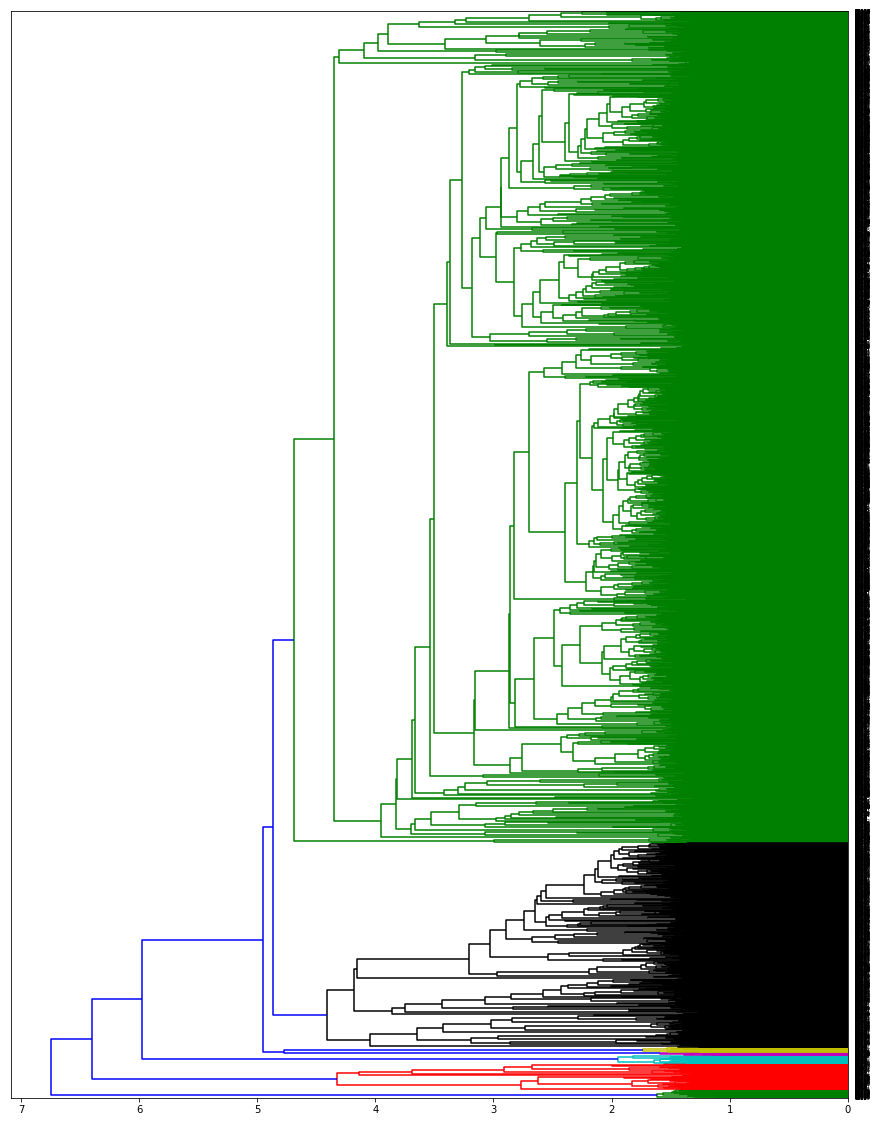

In [136]:
%%time 
y=vector_ne
#d1=dendrogram(linkage(y,method='ward'))
fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage(y,method='ward'), orientation="left")
plt.savefig('hierachical_clusters_negative-more.png', dpi=200)

In [139]:
k=7
hc=AgglomerativeClustering(n_clusters = k, affinity='euclidean',linkage='ward')

In [140]:
%%time
hc_fit=hc.fit_predict(y)

CPU times: user 3min 57s, sys: 2.9 s, total: 4min
Wall time: 4min 3s


In [141]:
# plt.scatter(y[hc_fit==0,0],y[hc_fit==0,1],s=10,c='blue')
# plt.scatter(y[hc_fit==1,0],y[hc_fit==1,1],s=10,c='yellow')
# plt.scatter(y[hc_fit==2,0],y[hc_fit==2,1],s=10,c='red')
# plt.scatter(y[hc_fit==3,0],y[hc_fit==3,1],s=10,c='green')
# plt.scatter(y[hc_fit==4,0],y[hc_fit==4,1],s=10,c='black')

In [142]:
ne['cluster']=hc_fit
cluster_statistics=ne.groupby('cluster').count()
dict_of_groups = {k: v for k, v in ne.groupby('cluster')}
cluster0 = dict_of_groups[0]
cluster1 = dict_of_groups[1]
cluster2 = dict_of_groups[2]
cluster3 = dict_of_groups[3]
cluster4 = dict_of_groups[4]
cluster5 = dict_of_groups[5]
cluster6 = dict_of_groups[6]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [147]:
writer=pd.ExcelWriter('negative_cluster_more.xlsx')
ne.to_excel(writer,sheet_name='all_clusters',index=False)
cluster0.to_excel(writer,sheet_name='cluster0',index=False)
cluster1.to_excel(writer,sheet_name='cluster1',index=False)
cluster2.to_excel(writer,sheet_name='cluster2',index=False)
cluster3.to_excel(writer,sheet_name='cluster3',index=False)
cluster4.to_excel(writer,sheet_name='cluster4',index=False)
cluster5.to_excel(writer,sheet_name='cluster5',index=False)
cluster6.to_excel(writer,sheet_name='cluster6',index=False)
writer.save()

# Hierarchical document clustering¶for positive reviews

CPU times: user 4min 37s, sys: 6.58 s, total: 4min 44s
Wall time: 4min 49s


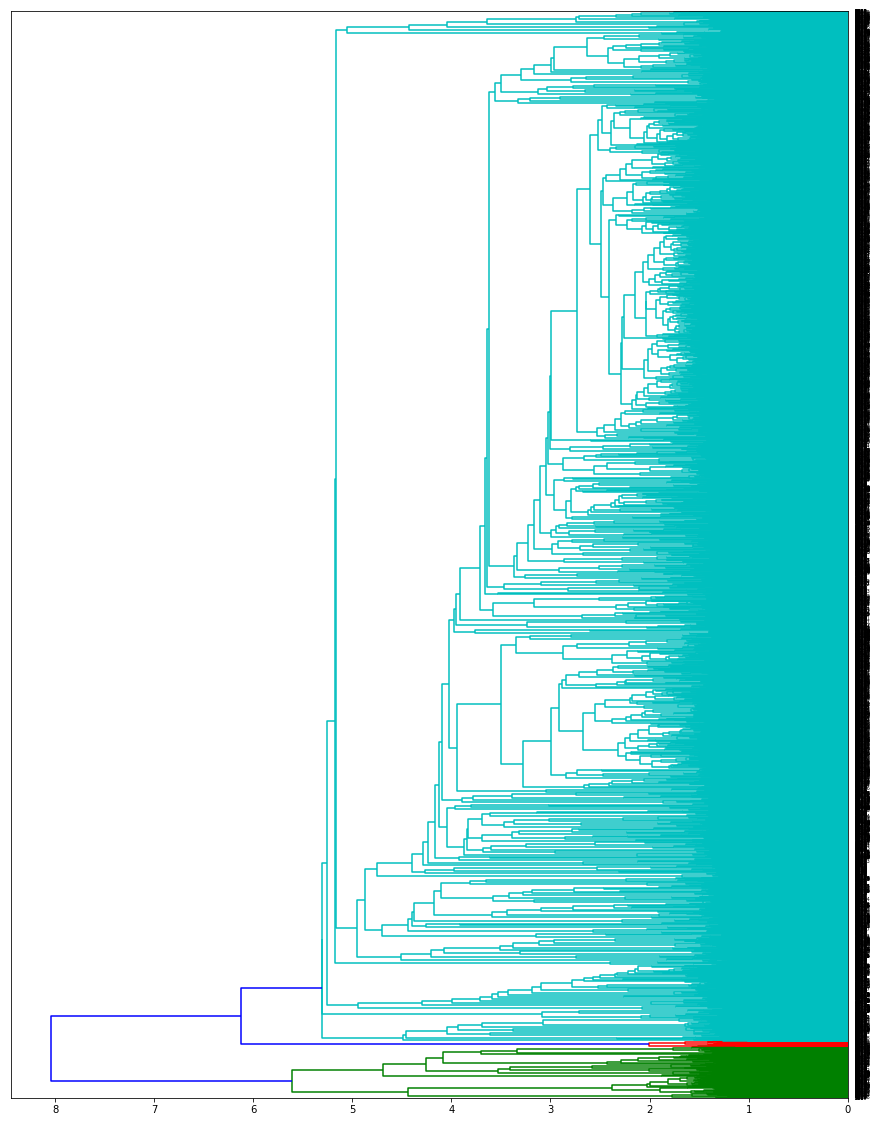

In [148]:
%%time 
y=vector_po
#d1=dendrogram(linkage(y,method='ward'))
fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage(y,method='ward'), orientation="left")
plt.savefig('hierachical_clusters_positive_more.png', dpi=200)

In [149]:
k=3
hc=AgglomerativeClustering(n_clusters = k, affinity='euclidean',linkage='ward')

In [150]:
hc_fit=hc.fit_predict(y)

In [152]:
po['cluster']=hc_fit
cluster_statistics=ne.groupby('cluster').count()
dict_of_groups = {k: v for k, v in po.groupby('cluster')}
cluster0 = dict_of_groups[0]
cluster1 = dict_of_groups[1]
cluster2 = dict_of_groups[2]
# cluster3 = dict_of_groups[3]
# cluster4 = dict_of_groups[4]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [153]:
writer=pd.ExcelWriter('positive_cluster_more.xlsx')
po.to_excel(writer,sheet_name='all_clusters',index=False)
cluster0.to_excel(writer,sheet_name='cluster0',index=False)
cluster1.to_excel(writer,sheet_name='cluster1',index=False)
cluster2.to_excel(writer,sheet_name='cluster2',index=False)
# cluster3.to_excel(writer,sheet_name='cluster3',index=False)
# cluster4.to_excel(writer,sheet_name='cluster4',index=False)
# cluster5.to_excel(writer,sheet_name='cluster5',index=False)
# cluster6.to_excel(writer,sheet_name='cluster6',index=False)
writer.save()

In [7]:
import pandas as pd
cluster_po=pd.read_excel('positive_cluster_more.xlsx',sheet_name=None)

In [8]:
cluster_ne=pd.read_excel('negative_cluster_more.xlsx',sheet_name=None)

In [12]:
posta=cluster_po['all_clusters'].groupby('cluster').count()

In [13]:
nesta=cluster_ne['all_clusters'].groupby('cluster').count()

In [15]:
posta['percentage']=posta['sentiment']/posta['sentiment'].sum()

In [16]:
posta

,review,sentiment,percentage
cluster,,,
0,593,593,0.047550
1,11822,11822,0.947959
2,56,56,0.004490


In [17]:
nesta['percentage']=nesta['sentiment']/nesta['sentiment'].sum()

In [18]:
nesta

,review,sentiment,percentage
cluster,,,
0,9522,9522,0.765988
1,91,91,0.007320
2,2327,2327,0.187193
3,97,97,0.007803
4,55,55,0.004424
5,298,298,0.023972
6,41,41,0.003298
